# Graph Neural Networks: Cora Dataset Pytorch

El "Cora Dataset" es un dataset de clasificación de documentos. Contiene 2708 documentos científicos clasificados en una de las siguientes categorías:

- Case_Based
- Genetic_Algorithms
- Neural_Networks
- Probabilistic_Methods
- Reinforcement_Learning
- Rule_Learning
- Theory

Cada nodo representa un documento, y cada arista representa una citación entre dos documentos.

Los nodos contienen características de texto que se han extraído de los documentos. Por ejemplo: el título del artículo, las palabras clave y el resumen.
 
El objetivo es entrenar un modelo de GNN para predecir la categoría de cada documento.

In [55]:
from typing import Callable, List, Optional, Tuple
import random

import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from typing_extensions import Literal, TypedDict

Los nodos se cargan desde `cora.content` y las aristas desde `cora.cites`. El archivo `cora.content` contiene una fila por nodo, y la primera columna representa el ID del nodo. Las columnas restantes representan las características de los nodos, que incluyen:

- 1433 características binarias que representan la presencia / ausencia de palabras clave del vocabulario de la bolsa de palabras.
- 1 característica binaria que representa la presencia / ausencia de la palabra clave "references" (en el documento original, esta característica se utiliza para distinguir los documentos de la base de datos de los documentos de la bibliografía).
- 1 característica numérica que representa el año de publicación del documento.

Las aristas se cargan como una lista de pares de nodos (origen, destino), donde cada par representa una arista desde el nodo de origen al nodo de destino.


In [56]:
dataset = Planetoid("/tmp/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
# For num. edges see:
# - https://github.com/pyg-team/pytorch_geometric/issues/343
# - https://github.com/pyg-team/pytorch_geometric/issues/852
num_edges = dataset.data.num_edges // 2
train_len = dataset[0].train_mask.sum()
val_len = dataset[0].val_mask.sum()
test_len = dataset[0].test_mask.sum()
other_len = num_nodes - train_len - val_len - test_len
print(f"Dataset: {dataset.name}")
print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
print(f"Num. edges: {num_edges}")
print(f"Num. node features: {dataset.num_node_features}")
print(f"Num. classes: {dataset.num_classes}")
print(f"Dataset len.: {dataset.len()}")

Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1


c:\Users\icira\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [57]:
dataset = Planetoid("/tmp/Cora", name="Cora")
print(f"Sum of row values without normalization: {dataset[0].x.sum(dim=-1)}")

dataset = Planetoid("/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
print(f"Sum of row values with normalization: {dataset[0].x.sum(dim=-1)}")

Sum of row values without normalization: tensor([ 9., 23., 19.,  ..., 18., 14., 13.])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


In [45]:
class GCN(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        num_classes: int,
        hidden_dim: int = 16,
        dropout_rate: float = 0.5,
    ) -> None:
        super().__init__()
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x: Tensor, edge_index: Tensor) -> torch.Tensor:
        x = self.dropout1(x)
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.conv2(x, edge_index)
        return x

In [46]:
print("Graph Convolutional Network (GCN):")
GCN(dataset.num_node_features, dataset.num_classes)

Graph Convolutional Network (GCN):


GCN(
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv1): GCNConv(1433, 16)
  (relu): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(16, 7)
)

In [48]:
def accuracy(pred, target):
    r"""Computes the accuracy of predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.

    :rtype: int
    """
    return (pred == target).sum().item() / target.numel()

In [49]:
LossFn = Callable[[Tensor, Tensor], Tensor]
Stage = Literal["train", "val", "test"]


def train_step(
    model: torch.nn.Module, data: Data, optimizer: torch.optim.Optimizer, loss_fn: LossFn
) -> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask = data.train_mask
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    # + L2 regularization to the first layer only
    # for name, params in model.state_dict().items():
    #     if name.startswith("conv1"):
    #         loss += 5e-4 * params.square().sum() / 2.0

    acc = accuracy(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model: torch.nn.Module, data: Data, loss_fn: LossFn, stage: Stage) -> Tuple[float, float]:
    model.eval()
    mask = getattr(data, f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    # + L2 regularization to the first layer only
    # for name, params in model.state_dict().items():
    #     if name.startswith("conv1"):
    #         loss += 5e-4 * params.square().sum() / 2.0

    acc = accuracy(preds, y)
    return loss.item(), acc

In [51]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]


def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = True,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history

In [52]:
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()


Epoch: 0
----------
Train loss: 1.9456 | Train acc: 0.1357
  Val loss: 1.9459 |   Val acc: 0.1080

Epoch: 20
----------
Train loss: 1.7069 | Train acc: 0.7786
  Val loss: 1.8023 |   Val acc: 0.5740

Epoch: 40
----------
Train loss: 1.3244 | Train acc: 0.8143
  Val loss: 1.5744 |   Val acc: 0.7380

Epoch: 60
----------
Train loss: 0.9808 | Train acc: 0.8643
  Val loss: 1.3290 |   Val acc: 0.7560

Epoch: 80
----------
Train loss: 0.7544 | Train acc: 0.8643
  Val loss: 1.1251 |   Val acc: 0.7840

Epoch: 100
----------
Train loss: 0.5765 | Train acc: 0.9357
  Val loss: 1.0017 |   Val acc: 0.7860

Epoch: 120
----------
Train loss: 0.5093 | Train acc: 0.9500
  Val loss: 0.9663 |   Val acc: 0.7700

Early stopping...

Epoch: 132
----------
Train loss: 0.4602 | Train acc: 0.9571
  Val loss: 0.9237 |   Val acc: 0.7780
 Test loss: 0.8932 |  Test acc: 0.8020


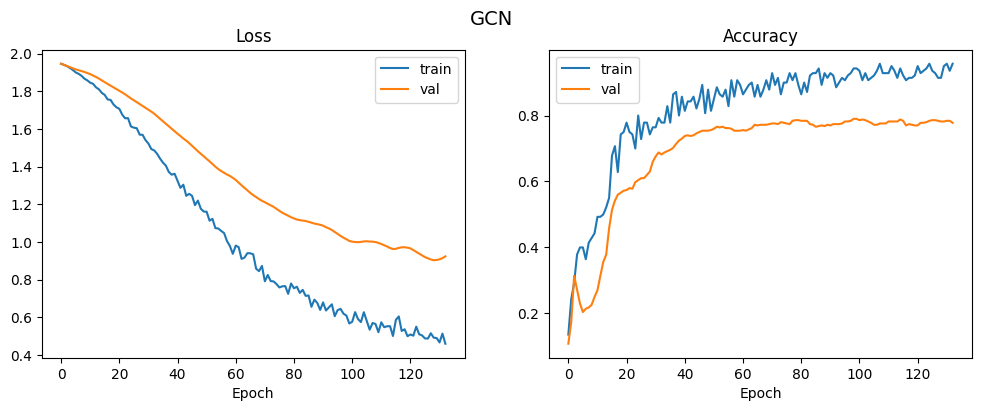

In [53]:
SEED = 42
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10


torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(dataset.num_node_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

plt.figure(figsize=(12, 4))
plot_history(history, "GCN")

# Graph Neural Networks: Cora Dataset Pytorch

El "Cora Dataset" es un dataset de clasificación de documentos. Contiene 2708 documentos científicos clasificados en una de las siguientes categorías:

- Case_Based
- Genetic_Algorithms
- Neural_Networks
- Probabilistic_Methods
- Reinforcement_Learning
- Rule_Learning
- Theory

Cada nodo representa un documento, y cada arista representa una citación entre dos documentos.

Los nodos contienen características de texto que se han extraído de los documentos. Por ejemplo: el título del artículo, las palabras clave y el resumen.
 
El objetivo es entrenar un modelo de GNN para predecir la categoría de cada documento.

In [28]:
import  torch
import  torch.nn.functional     as F
from    torch_geometric.nn      import GCNConv
from torch_geometric.data import Data
import  numpy                   as np
import  pandas                  as pd
from    sklearn.preprocessing   import  LabelEncoder

In [29]:
# Load data
cora_df         = pd.read_csv('cora/cora.content', header=None, sep='\t')
cora_cites      = pd.read_csv('cora/cora.cites', header=None, sep='\t')

cora_df   
labels          = cora_df.iloc[:, -1].values
le              = LabelEncoder()
labels_y        = le.fit_transform(labels)
edge_index      = torch.tensor(cora_cites.values.T, dtype=torch.long)

node_ids        = cora_df.iloc[:, 0].values
id_map          = {node_id: i for i, node_id in enumerate(node_ids)}
cora_df[0].replace(id_map, inplace=True)
cora_cites[0]   = cora_cites[0].map(id_map)
cora_cites[1]   = cora_cites[1].map(id_map)


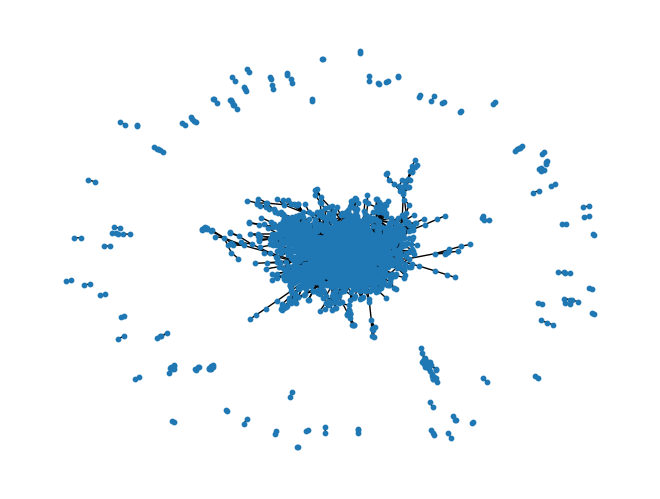

In [30]:
# Visualize the graph
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph()
G.add_nodes_from(range(len(labels)))
G.add_edges_from(cora_cites.values)
nx.draw(G, node_size=10)
plt.show()


In [32]:
# Get the node features and the target labels
node_features   = torch.randn(10, 5)                                                                    
edge_index      = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]])
labels          = torch.tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])                                          
train_mask      = torch.tensor([True, True, False, False, True, True, False, False, False, False])
test_mask       = torch.tensor([False, False, False, False, False, False, False, False, True, True])
data1           = Data(x=node_features, edge_index=edge_index, y=labels, train_mask=train_mask, test_mask=test_mask)            


# and the following is our final preprocess result
node_features2  = torch.tensor(np.array(cora_df.iloc[:, 1:-1]), dtype=torch.float)   
edge_index2     = torch.tensor(cora_cites.values.T, dtype=torch.int64)
labels2         = torch.tensor(labels_y, dtype=torch.int64) 
train_mask2     = torch.tensor([True]*1500 + [False]*1208)
test_mask2      = torch.tensor([False]*1500 + [True]*1208)
data2           = Data(x=node_features2, edge_index=edge_index2, y=labels2, train_mask=train_mask2, test_mask=test_mask2)

In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

# Load Cora dataset
dataset = Planetoid(root='/tmp/cora', name='Cora')      # This is very simple for us to demo.
data_we_want    = dataset[0]
data_we_want.x              # this is very important
data_we_want.edge_index     # and we should focus on 
data_we_want.y              # these data form
data_we_want.train_mask     # and if you are sensitive 
data_we_want.val_mask       # you will find it's all
data_we_want.test_mask      # built by tensor

Processing...
Done!


tensor([False, False, False,  ...,  True,  True,  True])

In [22]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=16).to(device)
data_t = data2.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [24]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_t.x, data_t.edge_index)
    loss = F.nll_loss(out[data_t.train_mask], data_t.y[data_t.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data_t.x, data_t.edge_index)
    pred = out.argmax(dim=1)
    acc = (pred[data_t.test_mask] == data_t.y[data_t.test_mask]).sum().item() / data_t.test_mask.sum().item()
    return acc



In [26]:
for epoch in range(1, 201):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Epoch: 010, Loss: 0.1738, Accuracy: 0.8005
Epoch: 020, Loss: 0.1777, Accuracy: 0.8005
Epoch: 030, Loss: 0.1753, Accuracy: 0.7972
Epoch: 040, Loss: 0.1711, Accuracy: 0.7997
Epoch: 050, Loss: 0.1690, Accuracy: 0.7988
Epoch: 060, Loss: 0.1641, Accuracy: 0.7964
Epoch: 070, Loss: 0.1723, Accuracy: 0.7972
Epoch: 080, Loss: 0.1559, Accuracy: 0.7988
Epoch: 090, Loss: 0.1597, Accuracy: 0.7997
Epoch: 100, Loss: 0.1675, Accuracy: 0.7914
Epoch: 110, Loss: 0.1743, Accuracy: 0.7955
Epoch: 120, Loss: 0.1721, Accuracy: 0.7955
Epoch: 130, Loss: 0.1488, Accuracy: 0.7955
Epoch: 140, Loss: 0.1555, Accuracy: 0.7922
Epoch: 150, Loss: 0.1600, Accuracy: 0.7980
Epoch: 160, Loss: 0.1515, Accuracy: 0.7972
Epoch: 170, Loss: 0.1551, Accuracy: 0.7972
Epoch: 180, Loss: 0.1637, Accuracy: 0.7914
Epoch: 190, Loss: 0.1507, Accuracy: 0.7939
Epoch: 200, Loss: 0.1510, Accuracy: 0.7906
